In [1]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

import torch
import torch.nn as nn


import torch.distributions as dis

In [2]:
test = torch.rand(10, 5)
test2 = torch.rand(10, 5)

In [3]:
MN_dist_good = dis.multivariate_normal.MultivariateNormal(torch.mean(test, dim=0), torch.cov(torch.transpose(test, 0, 1)))
MN_dist_bad = dis.multivariate_normal.MultivariateNormal(torch.mean(test2, dim=0), torch.cov(torch.transpose(test2, 0, 1)))

In [4]:
criterion2 = nn.KLDivLoss(log_target=True, reduction="batchmean")
samp = MN_dist_good.sample((10,))
criterion2(MN_dist_good.log_prob(samp), MN_dist_bad.log_prob(samp))

tensor(0.1544)

In [5]:
MN_dist_good.arg_constraints = {'loc': }

SyntaxError: invalid syntax (Temp/ipykernel_10492/3509829829.py, line 1)

In [6]:
MN_dist_good.log_prob(MN_dist_good.sample((10,)))

tensor([ 0.2850,  0.7382, -0.5217, -0.0966, -0.0070, -0.5531, -1.6853, -6.6117,
         0.2243, -1.5264])

In [7]:
torch.cov(torch.transpose(test, 0, 1))

tensor([[ 0.1025,  0.0151, -0.0152, -0.0444, -0.0353],
        [ 0.0151,  0.0905, -0.0164,  0.0177,  0.0592],
        [-0.0152, -0.0164,  0.1346,  0.0020, -0.0121],
        [-0.0444,  0.0177,  0.0020,  0.1220,  0.0302],
        [-0.0353,  0.0592, -0.0121,  0.0302,  0.1012]])

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

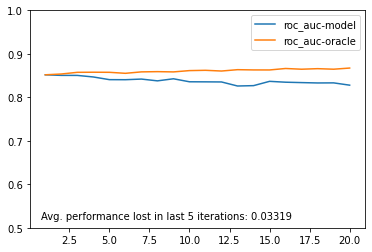

Sampling Bias: 0.03319


In [15]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)#rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [9]:
print(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years))

0.03267919203026985


## Test importable Autoencoder

In [103]:
import autoencoder as aenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Users\\haase.PAPMEIER\\InfSys\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=20, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=20, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=68, bias=True)
  )
)
Epoch 1 of 40, Train Loss: 0.648
Epoch 2 of 40, Train Loss: 0.539
Epoch 3 of 40, Train Loss: 0.482
Epoch 4 of 40, Train Loss: 0.454
Epoch 5 of 40, Train Loss: 0.440
Epoch 6 of 40, Train Loss: 0.431
Epoch 7 of 40, Train Loss: 0.425
Epoch 8 of 40, Train Loss: 0.422
Epoch 9 of 40, Train Loss: 0.420
Epoch 10 of 40, Train Loss: 0.418
Epoch 11 of 40, Train Loss: 0.417
Epoch 12 of 40, Train Loss: 0.416
Epoch 13 of 40, Train Loss: 0.415
Epoch 14 of 40, Train Loss: 0.414
Epoch 15 of 40, Train Loss: 0.414
Epoch 16 of 40, Train Loss: 0.413
Epoch 17 of 40, Train Loss: 0.412
Epoch 18 of 40, Train Loss: 0.412
Epoch 19 of 40, Train Loss: 0.412
Epoch 20 of 40, Train Loss: 0.411
Epoch 21 of 40, Train Lo

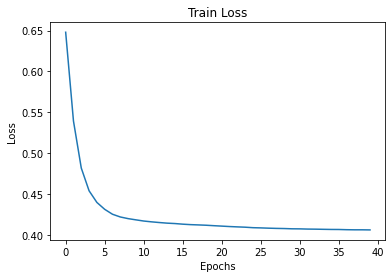

In [104]:
BATCH_SIZE = 300
EPOCHS = 40

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

shape = [dataset.x.shape[1], 35, 20, 35, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss = aenc.train(net, data_loader, EPOCHS)               

plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 20)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 20)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 20)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 20)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 20)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 20)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 20)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 20)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 20)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 20)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 20)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 20)
Itteration: 12) Accepted: 1821 | Denied: 4254 - Ne

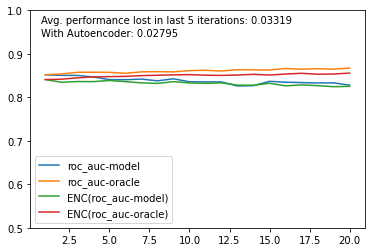

In [105]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()